# Bell Ville (Argentina) data analysis

## Sentinel-1 processing

* using SNAP and SNAP graph/processing pipeline
* standard steps: Apply precise orbit, thermal noise removal, remove GRD border noise, calibration, terrain correction (DEM: 30m Copernicus global) 10m pixel spacing, subset to region, linear to dB conversion
* calculation of RVI using `create-rvi-tif` python script


## NovaSAR  processing

* download SCD geotiff files from CSIRO
* convert to lat/lon raster using gdal (=geocoding)
* manually correct geolocation, because of incorrect positions (even with better GPS orbit position instead of less accurate TLE)
* calibrate (DN to linear) using numpy and calibration constant from metadata (see `calibrate-novasar` python script) and conversion to logarithmic/dB scale
* for incidence angle
  * SNAP graph (`2024-s-band-paper-graphs/2024-07-10-novasar-incidence-angle.xml`) then processing all five images
  * setting 0 as no data (`for f in (ls NV_*.tif); gdal_edit.py -a_nodata 0 $f; end`)
  * compressing and renaming/copying to directories
  * no correction is applied for geolocalisation error (error in one example: 0.1°)
  * compress the files using `gdal_translate -co COMPRESS=PACKBITS` and rename them (one example command: `gdal_translate -co COMPRESS=PACKBITS snap-procs-incidence-angle/NV_01_00C701_BandMath_TC.tif NovaSAR_01_50945_scd_231224_014907_HH_HV/NovaSAR_01_50945_scd_32_231224_014907_HH_HV/incidence_angle.tif`)

## Sentinel-2 processing/NDVI calculation

* using custom methods in each notebook
* masking using SCL layer

# Python imports

In [1]:
import geopandas as gpd
import pandas as pd
import os
from pathlib import Path
import numpy as np
import rasterio
import rasterio.mask
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

In [2]:
import multifrequtils
from multifrequtils import (
    get_s2_zip_files, scatterplot_nice, get_s2_ndvi_files, compute_zonal_stats_rasterio_opened,
    add_cr, get_filtered_pearsons_r
)

In [3]:
pd.set_option("display.max_rows", 10)
pd.set_option("display.min_rows", 2)

# Definitions

In [4]:
data_dir = Path("/run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/")

In [5]:
s2_img_dir = data_dir / "data s2 southamerica"
s1_img_dir = data_dir / "data s1 southamerica"
novasar_img_dir = data_dir / "data-bell-ville-processed/novasar"
vector_file_path = data_dir / 'fields-bell-ville.geojson'
classification_file = data_dir / "2024-10-21 national crops argentina" / "RF_ver_zonaVI_RF_V4_REM.tif"
assert classification_file

In [6]:
today_str = multifrequtils.get_today_str()
fig_out_dir = data_dir / f"{today_str}-figures-bell-ville"
fig_out_dir.mkdir(exist_ok=True)

In [7]:
correlation_coeffs = list()  # to store the extracted values of all fields

In [8]:
polygons = gpd.read_file(vector_file_path)
polygons

,polygon_id,geometry
0,0,"POLYGON ((-62.72765 -32.55991, -62.72855 -32.5..."
...,...,...
204,204,"POLYGON ((-62.56095 -32.56744, -62.56297 -32.5..."


In [9]:
polygons["area_ha"] = polygons.to_crs('epsg:32720').geometry.area / 10_000
polygons["area_ha"].mean(), polygons["area_ha"].median()

(33.13719097236159, 29.652825281084713)

In [10]:
polygons["area_ha"].quantile([0, 0.05, 0.1, 0.2, 0.5, 0.6, 0.7, 1.])

0.00      4.446577
0.05      7.755182
0.10      9.781185
0.20     13.998516
0.50     29.652825
0.60     35.674236
0.70     42.342502
1.00    113.045541
Name: area_ha, dtype: float64

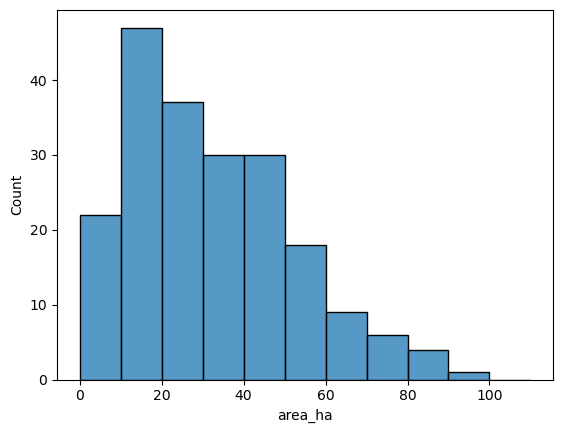

In [11]:
sns.histplot(x="area_ha", data=polygons, bins=np.arange(0, 120, 10))
plt.savefig(fig_out_dir / "polygon-fieldsize-distribution.png")

## Zonal statistics methods

In [12]:
def compute_zonal_stats_rasterio(raster_path, polygons, raster_transformation_func=None, band_idx=0):
    with rasterio.open(raster_path) as src:
        stats_list = compute_zonal_stats_rasterio_opened(polygons=polygons, raster_ds=src, raster_transformation_func=raster_transformation_func, band_idx=band_idx)
    stats_list = [s for s in stats_list if s["count"] > 75]  # 0.5ha at 10m resolution (100m*100m=1ha=100px@10m)
    return stats_list

# Get raster file paths

## NovaSAR

In [13]:
def get_novasar_raster_files(novasar_img_dir):
    raster_files, rvi_files, incidence_files = list(), list(), list()
    possible_polarizations = ["HH", "HV", "VV"]
    files_list = list()  # contains dict for each scene
    
    for novasar_dir in novasar_img_dir.glob("NovaSAR*"):
        files = dict()
        assert novasar_dir.is_dir(), novasar_dir
        novasar_tifs = list(novasar_dir.glob("image_*-linear.tif"))
        # for each possible polarization, find the file and add it to dict
        for pol in possible_polarizations:
            pol_filter_func = lambda f: pol in f.name
            pol_files = list(filter(pol_filter_func, novasar_tifs))
            if len(pol_files) == 1:
                files[pol] = pol_files[0]
            elif len(pol_files) > 1:
                raise Error("Expected at most one file for a polarization.", pol, novasar_tifs)
            
        incidence_tif = novasar_dir / "incidence_angle.tif"
        assert incidence_tif.is_file(), ("Didn't find file!", incidence_tif)
        files["incidence"] = incidence_tif

        metadata_file = novasar_dir / "metadata.xml"
        assert metadata_file.is_file(), ("Didn't find file!", metadata_file)
        files["metadata"] = metadata_file
        
        rvi_tifs = list(novasar_dir.glob("image_*-RVI.tif"))
        assert len(rvi_tifs) == 1, ("Expect only one file", rvi_tifs)
        files["RVI"] = rvi_tifs[0]

        files_list.append(files)

    return files_list

In [14]:
novasar_files = get_novasar_raster_files(novasar_img_dir)

## Sentinel-2

In [15]:
s2_zip_files = get_s2_zip_files(s2_img_dir)
len(set(s2_zip_files))

57

In [16]:
ndvi_files = get_s2_ndvi_files(ndvi_img_dir=s2_img_dir)
len(set(ndvi_files))

9

## Sentinel-1

In [17]:
def get_s1_snap_processed_files(s1_dir):
    s1_rasters = list()
    # Subset_S1A_IW_GRDH_1SDV_20220121T194103_20220121T194128_041563_04F181_1F44_Orb_NR_Cal_TC_VV|VH.tif
    # Subset_S1A_IW_GRDH_1SDV_20220602T194106_20220602T194131_043488_05314A_3B6B_Orb_NR_Cal_TC_dB.tif
    # Subset_S1A_IW_GRDH_1SDV_20220121T194103_20220121T194128_041563_04F181_1F44_Orb_NR_Cal_TC_dB.tif
    db_rasters = list(s1_img_dir.glob("Subset_S1A_IW_GRDH*dB.tif"))
    return db_rasters

s1_raster_files = get_s1_snap_processed_files(s1_dir=s1_img_dir)
s1_rvi_files = list(s1_img_dir.glob("Subset_S1A_IW_GRDH*_RVI.tif"))
assert len(s1_rvi_files) == len(s1_raster_files)
s1_raster_files

[PosixPath('/run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data s1 southamerica/Subset_S1A_IW_GRDH_1SDV_20240113T093121_20240113T093146_052086_064B96_8E9A_Orb_NR_Cal_TC_dB.tif'),
 PosixPath('/run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data s1 southamerica/Subset_S1A_IW_GRDH_1SDV_20231220T093122_20231220T093147_051736_063F9A_1A8A_Orb_NR_Cal_TC_dB.tif'),
 PosixPath('/run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data s1 southamerica/Subset_S1A_IW_GRDH_1SDV_20240101T093122_20240101T093147_051911_064599_1C68_Orb_NR_Cal_TC_dB.tif'),
 PosixPath('/run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data s1 southamerica/Subset_S1A_IW_GRDH_1SDV_20240301T093120_20240301T093145_052786_066342_4B21_Orb_NR_Cal_TC_dB.tif'),
 PosixPath('/run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data s1 southamerica/Subset_S1A_IW_GRDH_1SDV_20240218T093120_20240218T093145_052611_065D46_830A_Orb_NR_Cal_TC_dB.tif'),
 PosixPath('/run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data s1 so

# Convert S2 zips to ndvi tifs
This is only needed to run once, after that the saved NDVI tifs are used

In [18]:
#for s2_zip in tqdm(s2_zip_files):
#    open_s2_and_save_ndvi_img(s2_zip, ndvi_tif_dir=s2_img_dir)

# Extract statistical values from the raster files for all fields

## Classification/crop type map

In [19]:
category_map = {10: "Maize", 11: "Soybean",	22: "No cropland", 255: "empty", 18: "Sunflower (Summer Crop)", 12: "Sunflower"}
stats_classification = multifrequtils.compute_zonal_classification_stats(classifications_raster=classification_file, polygons=polygons, category_map=category_map)
stats_classification[:2]

,geometry,polygon_id,area_ha,Maize,Soybean,No cropland,empty,Sunflower (Summer Crop),Sunflower,pixel_sum,primary_class,primary_class_fraction,secondary_class,secondary_class_fraction
0,"POLYGON ((-62.72765 -32.55991, -62.72855 -32.5...",0,39.994673,1.0,528.0,NaN,NaN,NaN,NaN,529.0,Soybean,0.998110,Maize,0.001890
1,"POLYGON ((-62.72869 -32.56423, -62.73078 -32.5...",1,42.628738,557.0,7.0,NaN,NaN,NaN,NaN,564.0,Maize,0.987589,Soybean,0.012411


In [20]:
crop_classes, crop_class_counts = np.unique(stats_classification.primary_class, return_counts=True)
crop_class_percentages = ((crop_class_counts / sum(crop_class_counts)) * 100)
crops = pd.DataFrame([crop_class_counts, crop_class_percentages], columns=crop_classes, index=["absolute", "percentage"])
crops

,Maize,No cropland,Soybean,empty
absolute,75.000000,46.000000,83.000000,1.000000
percentage,36.585366,22.439024,40.487805,0.487805


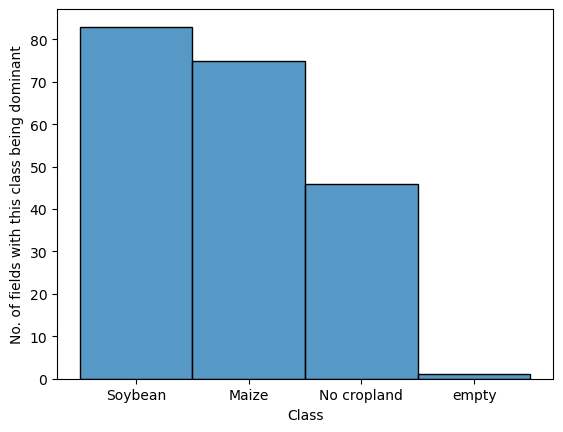

In [21]:
sns.histplot(stats_classification, x="primary_class")
plt.xlabel("Class")
plt.ylabel("No. of fields with this class being dominant")
plt.savefig(fig_out_dir / "classification-primaryclass-occurences.jpg")

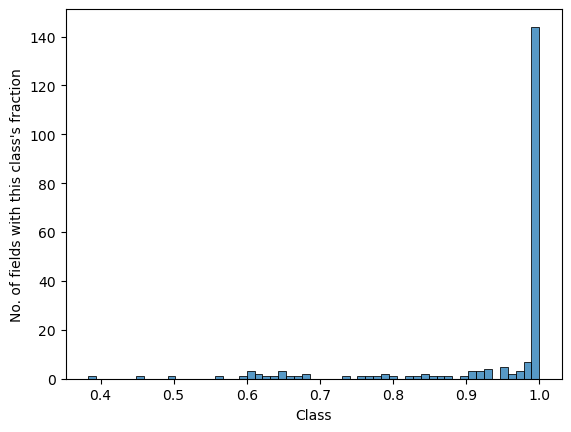

In [22]:
sns.histplot(stats_classification, x="primary_class_fraction")
plt.xlabel("Class")
plt.ylabel("No. of fields with this class's fraction")
plt.savefig(fig_out_dir / "classification-primaryclass-fractions.jpg")

## Sentinel-2

In [23]:
novasar_s2_date_mapping = {
    # novasar_date: s2_date
    '20231224': "20231225",
    '20240102': "20240104",
    '20240119': "20240119",
    '20240216': "20240213",
    '20240303': "20240304",
    '20240325': "20240324",
}

In [24]:
s1_s2_date_mapping = {
    # s1_date : s2_date
    "20231220": "20231225",
    "20240101": "20240104", 
    "20240113": "20240119",
    "20240218": "20240213",
    "20240301": "20240304",
    "20240325": "20240324",
}

In [25]:
def get_s2_statistics(ndvi_files):
    stats = list()
    for s2_ndvi_file in tqdm(ndvi_files):
        # skipping S2 images we don't need statistics from, because originally there where more S2 images downloaded
        if not any([s2_date in s2_ndvi_file.stem for s2_date in novasar_s2_date_mapping.values()]):
            continue
        
        _stats_s2 = compute_zonal_stats_rasterio(polygons=polygons, raster_path=s2_ndvi_file)
        for d in _stats_s2:
            d["filename"] = s2_ndvi_file.stem
            stats.append(d)
    stats = pd.DataFrame(stats)
    return stats
    
stats_s2_df = get_s2_statistics(ndvi_files)

100%|██████████| 9/9 [00:01<00:00,  4.56it/s]


In [26]:
_s2_dates = stats_s2_df.loc[:, "filename"].map(lambda f: f.split("_")[2].split("T")[0]).copy()
stats_s2_df.loc[:, "date"] = _s2_dates
stats_s2_df

,mean,median,count,polygon_id,filename,date
0,0.778276,0.789675,3998,0,S2A_MSIL2A_20231225T140701_N0510_R110_T20HNK_2...,20231225
...,...,...,...,...,...,...
247,0.700374,0.754304,1704,204,S2A_MSIL2A_20240304T140711_N0510_R110_T20HNJ_2...,20240304


In [27]:
# overlapping tiles result in field polygons appearing two times at the same date from the two tiles
# so we just remove them
# this could be made slightly better by averaging from the different tiles. however, for one example
# polygon_id 17 the NDVI difference is <2%
stats_s2_df = stats_s2_df.drop_duplicates(subset=['polygon_id', 'date'])
stats_s2_df

,mean,median,count,polygon_id,filename,date
0,0.778276,0.789675,3998,0,S2A_MSIL2A_20231225T140701_N0510_R110_T20HNK_2...,20231225
...,...,...,...,...,...,...
247,0.700374,0.754304,1704,204,S2A_MSIL2A_20240304T140711_N0510_R110_T20HNJ_2...,20240304


### Add crop classification to S2 data

In [28]:
classification_data_to_add_columns = ['polygon_id', 'primary_class', 'primary_class_fraction', 'secondary_class', 'secondary_class_fraction']
stats_s2_df = stats_s2_df.merge(right=stats_classification[classification_data_to_add_columns],
                                how="outer",
                                on="polygon_id",
                               )

## Extract NovaSAR values

In [29]:
def geocode_novasar_raster(novasar_raster, out_crs="EPSG:4326"):
    geocode_cmd_template = "gdalwarp -tps -r bilinear -srcnodata 0 -dstnodata 0 -t_srs {crs} '{src}' '{dst}'"
    geocoded_outpath = novasar_raster.parent / (novasar_raster.stem + "_wgs84.tif")#"_utm.tif")
    
    if geocoded_outpath.is_file():
        pass
        #print(f"{Path(dst).parent} already geocoded. Skipping")
    else:
        geocode_cmd = geocode_cmd_template.format(crs=out_crs, src=str(novasar_raster), dst=str(geocoded_outpath))
        print(f"Running '{geocode_cmd}'")
        os.system(geocode_cmd)
    return geocoded_outpath

In [30]:
def read_inc_angle(metadata_filepath):
    # <IncAngleCoeffs>27.075 0.00085775 -5.5288E-09 -2.2216E-14 -7.7528E-18 2.6808E-21 </IncAngleCoeffs>
    with open(metadata_filepath, "r") as fd:
        lines = fd.readlines()
        angle_line = list(filter(lambda l: "IncAngleCoeffs" in l, lines))
        assert len(angle_line) == 1
        angle_line = angle_line[0].strip()  # remove whitespace
        inc_angle = angle_line.split(">")[1].split(" ")[0]
    return inc_angle

In [31]:
def linear_to_db_novasar_raster(calibrated: np.ma.masked_array, calibration_constant=5.02e5):
    db_data = np.ones_like(calibrated)
    valid_mask = (calibrated > 0)                # negative values/zero are invalid for log10
    db_data[valid_mask] = calibrated[valid_mask] # copy usable values
    assert np.all(db_data.data > 0)
    
    db_data = 10 * np.log10(db_data)
    db_data = np.ma.masked_equal(db_data, 0)
    db_data.mask |= (calibrated == 0)
    assert type(db_data) == np.ma.core.MaskedArray, ("Type error.", type(db_data))

    return db_data

In [32]:
def get_poylgon_stats_novasar(novasar_files, polygons, raster_transformation_func=linear_to_db_novasar_raster):
    stats_novasar = list()
    
    for files in tqdm(novasar_files):
        incidence_angle_metadata = float(read_inc_angle(files["metadata"]))

        for dataname in ["HH", "HV", "RVI"]:
            _raster_transformation_func = None if dataname == "RVI" else raster_transformation_func
            stats_data = compute_zonal_stats_rasterio(raster_path=files[dataname], polygons=polygons, raster_transformation_func=_raster_transformation_func)
            stats_angle = compute_zonal_stats_rasterio(raster_path=files["incidence"], polygons=polygons, raster_transformation_func=None)
    
            # both statistics are not in sync anymore, because the raster files for incidence angle and backscatter have
            # different footprints because slightly different geolocatization correction
            # therefore this code is non standard compared to the other ones
            for d in stats_data: 
                # find the correct dict with the matching polygon id
                matching_angle_dict = list(filter(lambda d_angle: d["polygon_id"] == d_angle["polygon_id"], stats_angle))
                if len(matching_angle_dict) == 0:
                    continue
                assert len(matching_angle_dict) == 1, ("Error", len(matching_angle_dict))
                incidence_angle = matching_angle_dict[0]["median"]
                
                d["incidence_angle_metadata"] = incidence_angle_metadata
                d["filename"] = files[dataname]
                d["incidence_angle"] = incidence_angle
                d["polarization"] = dataname
                stats_novasar.append(d)
    stats_novasar = pd.DataFrame(stats_novasar)
    return stats_novasar

In [33]:
stats_novasar_df = get_poylgon_stats_novasar(novasar_files=novasar_files, 
                                             polygons=polygons, raster_transformation_func=linear_to_db_novasar_raster)

100%|██████████| 6/6 [00:32<00:00,  5.39s/it]


In [34]:
# NovaSAR_01_41494_scd_230127_020220_HH_HV
_novasar_dates = stats_novasar_df.loc[:, "filename"].map(lambda f: "20" + Path(f).parent.stem.split("_")[5]).copy()
stats_novasar_df.loc[:, "date"] = _novasar_dates
stats_novasar_df =  add_cr(data=stats_novasar_df, x="median", cross_pol="HV", co_pol="HH", date_col="date", cr_col="CR")
stats_novasar_df

,mean,median,count,polygon_id,incidence_angle_metadata,filename,incidence_angle,polarization,date
0,-6.870595,-6.822987,4230,0,27.052,/run/media/tom/SSDThomas/scratch/2024-05-s-ban...,28.851227,HH,20231224
...,...,...,...,...,...,...,...,...,...
3539,-4.669425,10.629578,2019,204,22.706,/run/media/tom/SSDThomas/scratch/2024-05-s-ban...,24.093025,CR,20240303


In [35]:
np.unique(stats_novasar_df.incidence_angle_metadata, return_counts=True)

(array([22.706, 24.904, 24.907, 27.052, 29.109, 29.166]),
 array([604, 532, 504, 812, 624, 464]))

In [36]:
np.unique(sorted(stats_novasar_df.date), return_counts=True)

(array(['20231224', '20240102', '20240119', '20240216', '20240303',
        '20240325'], dtype='<U8'),
 array([812, 624, 532, 464, 604, 504]))

#### Visualize data distributions

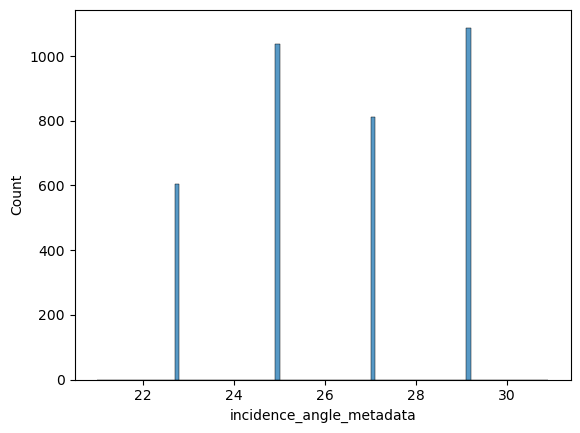

In [37]:
sns.histplot(x="incidence_angle_metadata", data=stats_novasar_df, bins=np.arange(21, 31, 0.1))
plt.savefig(fig_out_dir / "novasar-incidence-angle-metadata.png")

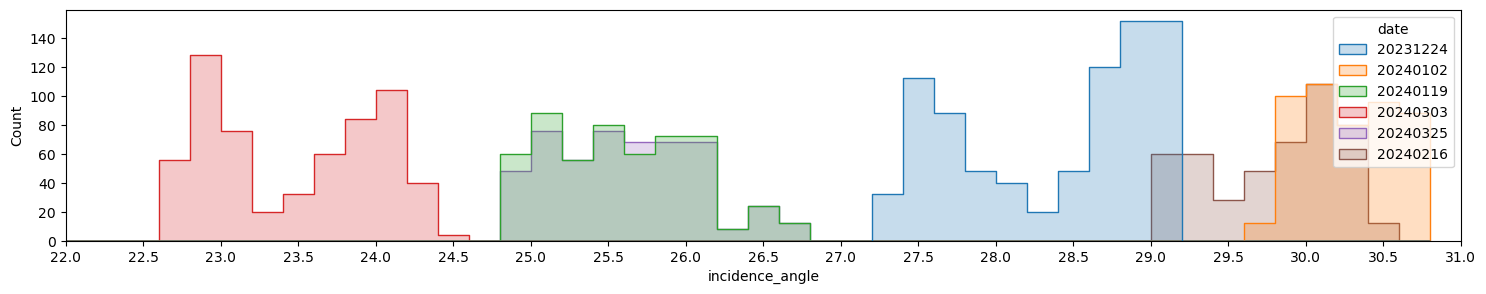

In [38]:
plt.figure(figsize=(18, 3))
ax = sns.histplot(x="incidence_angle", data=stats_novasar_df, hue="date", bins=np.arange(21, 31, 0.2), element="step")
ax.set_xticks(np.arange(22, 31.1, 0.5))
ax.set_xlim(22, 31)
plt.savefig(fig_out_dir / "novasar-incidence-angle.pdf")

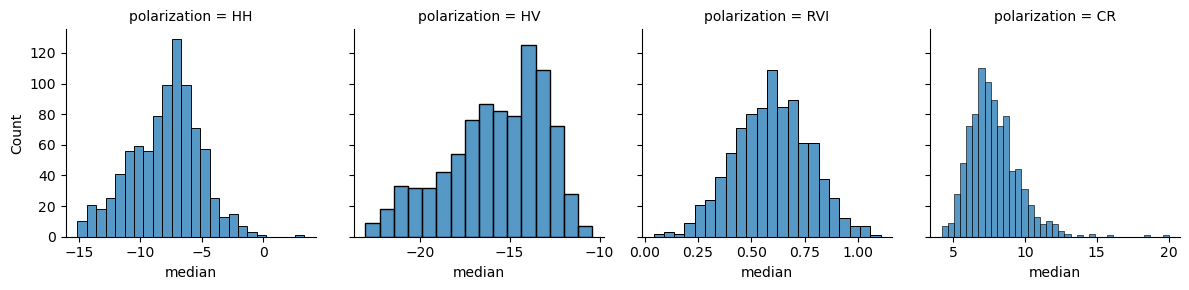

In [39]:
g = sns.FacetGrid(data=stats_novasar_df, col="polarization", sharex=False)
g.map_dataframe(sns.histplot, x="median")

## Extract S1 values

In [40]:
def get_s1_statistcs_dataframe(s1_rasters, s1_rvis, polygons):   
    stats = list()
    for s1_raster, s1_rvi in tqdm(zip(s1_rasters, s1_rvis), total=len(s1_rasters)):
        # skip S1 raster files we excluded
        if not any([s1_date in s1_raster.stem for s1_date in s1_s2_date_mapping.keys()]):
            continue

        _stats_vh = compute_zonal_stats_rasterio(raster_path=s1_raster, polygons=polygons, band_idx=0)
        _stats_vv = compute_zonal_stats_rasterio(raster_path=s1_raster, polygons=polygons, band_idx=1)
        _stats_lia = compute_zonal_stats_rasterio(raster_path=s1_raster, polygons=polygons, band_idx=2)
        _stats_rvi = compute_zonal_stats_rasterio(raster_path=s1_rvi, polygons=polygons, band_idx=0)
        
        for _stats, pol in zip([_stats_vv, _stats_vh, _stats_rvi], ["VV", "VH", "RVI"]):
            for d, lia in zip(_stats, _stats_lia):
                d["filename"] = s1_raster.stem
                d["polarization"] = pol
                d["local_incidence_angle"] = lia["mean"]
                stats.append(d)
    stats = pd.DataFrame(stats)
    return stats

def s1_add_date_using_filename(s1_df):
    # Subset_S1A_IW_GRDH_1SDV_20210806T194104_20210806T194129_039113_049D9A_1D7A_Orb_NR_Cal_TC_VH.tif
    date_func = lambda f: f.split("_")[5].split("T")[0]
    s1_dates = s1_df.loc[:, "filename"].map(date_func).copy()
    s1_df.loc[:, "date"] = s1_dates
    return s1_df

In [41]:
stats_s1 = get_s1_statistcs_dataframe(s1_rasters=s1_raster_files, s1_rvis=s1_rvi_files, polygons=polygons)
stats_s1 = s1_add_date_using_filename(stats_s1)
stats_s1 = add_cr(data=stats_s1, x="median", cross_pol="VH", co_pol="VV", date_col="date", cr_col="CR")
stats_s1

100%|██████████| 7/7 [00:22<00:00,  3.20s/it]


,mean,median,count,polygon_id,filename,polarization,local_incidence_angle,date
0,-8.352342,-8.269309,4765,0,Subset_S1A_IW_GRDH_1SDV_20240113T093121_202401...,VV,36.133057,20240113
...,...,...,...,...,...,...,...,...
4919,-12.312737,6.669735,2033,204,Subset_S1A_IW_GRDH_1SDV_20240325T093120_202403...,CR,35.193321,20240325


In [42]:
stats_s1.date.unique()

array(['20240113', '20231220', '20240101', '20240301', '20240218',
       '20240325'], dtype=object)

#### Data distribution plots

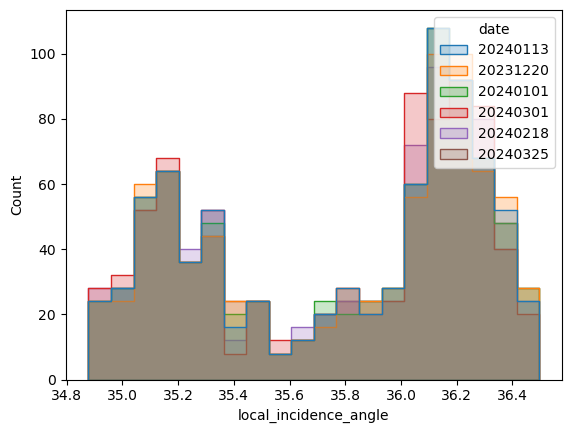

In [43]:
sns.histplot(data=stats_s1, x="local_incidence_angle", hue="date", element="step", bins=20)
plt.savefig(fig_out_dir / "s1-local_incidence_angle.png")

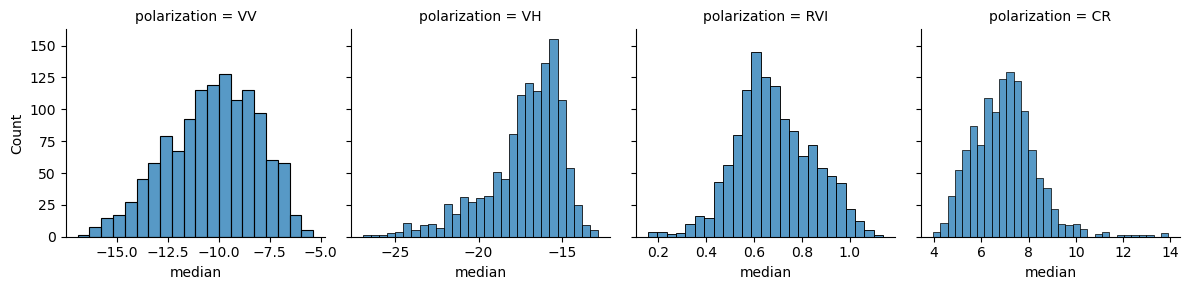

In [44]:
g = sns.FacetGrid(data=stats_s1, col="polarization", sharex=False)
g.map_dataframe(sns.histplot, x="median")

# Prepare values for visualization

## add dates to NovaSAR values

In [45]:
print("Nova:", list(sorted(stats_novasar_df.date.unique().tolist())))
print("  S2:", list(sorted(stats_s2_df.date.unique())))

Nova: ['20231224', '20240102', '20240119', '20240216', '20240303', '20240325']
  S2: ['20231225', '20240304']


In [46]:
_s2_date_of_novasar_img = stats_novasar_df.loc[:, "date"].map(lambda d: novasar_s2_date_mapping[d]).copy()
stats_novasar_df.loc[:, "s2_date"] = _s2_date_of_novasar_img
stats_novasar_df = stats_novasar_df[stats_novasar_df.loc[:, "s2_date"] != ""]
stats_novasar_df

,mean,median,count,polygon_id,incidence_angle_metadata,filename,incidence_angle,polarization,date,s2_date
0,-6.870595,-6.822987,4230,0,27.052,/run/media/tom/SSDThomas/scratch/2024-05-s-ban...,28.851227,HH,20231224,20231225
...,...,...,...,...,...,...,...,...,...,...
3539,-4.669425,10.629578,2019,204,22.706,/run/media/tom/SSDThomas/scratch/2024-05-s-ban...,24.093025,CR,20240303,20240304


# Visualization

## NovaSAR: Preparation and mangling

In [47]:
sensor = "novasar"

In [48]:
joined_novasar = stats_novasar_df.merge(right=stats_s2_df,  
                                how="outer",
                                left_on=('polygon_id', 's2_date'), 
                                right_on=('polygon_id', "date"), 
                                suffixes=('_novasar', '_s2'))
joined_novasar = joined_novasar[~pd.isnull(joined_novasar.s2_date)]

# there is one outlier, which is filtered away
joined_novasar = joined_novasar[((joined_novasar.median_novasar < 0) | joined_novasar.polarization.isin(["CR", "RVI"]))]
joined_novasar = joined_novasar[~((joined_novasar.median_novasar > 18) & joined_novasar.polarization.isin(["CR", "RVI"]))]
joined_novasar

,mean_novasar,median_novasar,count_novasar,polygon_id,incidence_angle_metadata,filename_novasar,incidence_angle,polarization,date_novasar,s2_date,mean_s2,median_s2,count_s2,filename_s2,date_s2,primary_class,primary_class_fraction,secondary_class,secondary_class_fraction
0,-6.870595,-6.822987,4230.0,0,27.052,/run/media/tom/SSDThomas/scratch/2024-05-s-ban...,28.851227,HH,20231224,20231225,0.778276,0.789675,3998.0,S2A_MSIL2A_20231225T140701_N0510_R110_T20HNK_2...,20231225,Soybean,0.99811,Maize,0.001890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3571,-4.669425,10.629578,2019.0,204,22.706,/run/media/tom/SSDThomas/scratch/2024-05-s-ban...,24.093025,CR,20240303,20240304,0.700374,0.754304,1704.0,S2A_MSIL2A_20240304T140711_N0510_R110_T20HNJ_2...,20240304,Maize,0.60000,Soybean,0.395556


In [49]:
joined_novasar.to_csv(fig_out_dir / "statistics-novasar-ndvi.csv")

In [50]:
list(sorted(joined_novasar.date_novasar.unique()))

['20231224', '20240102', '20240119', '20240216', '20240303', '20240325']

In [51]:
_joined = joined_novasar.copy()
nice_vis_dates = ["20231224", "20240102", "20240119", "20240216", "20240303"]
nice_vis_dates_str = " ". join(nice_vis_dates)
_joined = _joined[_joined.date_novasar.isin(nice_vis_dates)]

## NovaSAR: Visualization

In [52]:
datanames = ["HV", "HH", "CR", "RVI"]
xlims = [(-25, -9), (-20, 2), (3, None), (0, None)]
xlabels = ["backscatter [dB]", "backscatter [dB]", "cross-ratio [dB]", "RVI"]

### All fields, incidence angle colored

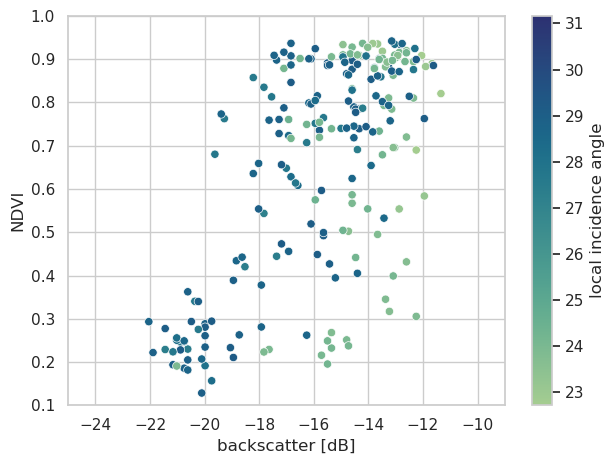

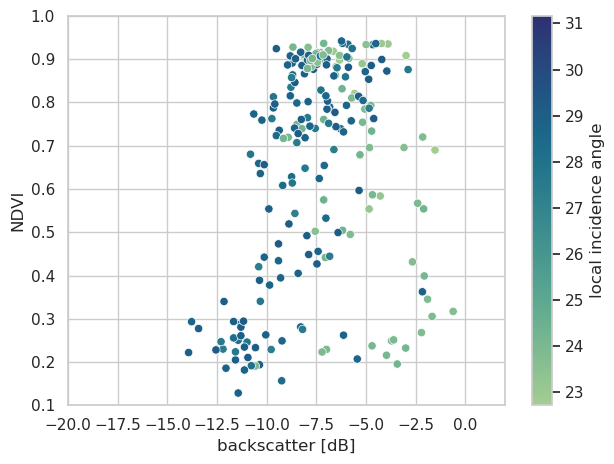

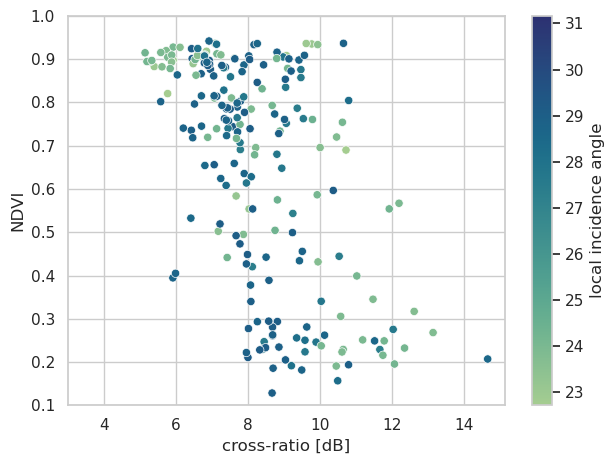

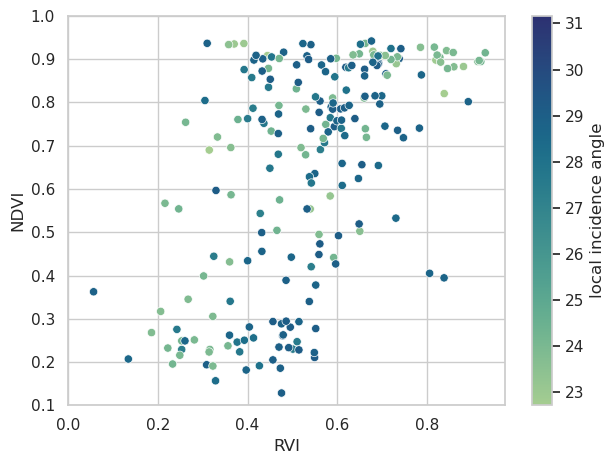

In [53]:
for dataname, xlim, xlabel in zip(datanames, xlims, xlabels):
    joined_pol = _joined[_joined.polarization == dataname]
    scatterplot_nice(x="median_novasar", y="median_s2", hue="incidence_angle", 
                     data=joined_pol,
                     xlabel=xlabel, ylabel="NDVI", huelabel="local incidence angle",
                     xlim=xlim,
                    )
    plt.savefig(fig_out_dir / f"novasar-{dataname.lower()}-ndvi-s2-colorincidence.pdf")
    plt.show()

    pearsonsr_pol = get_filtered_pearsons_r(x="median_novasar", y="median_s2", data=joined_pol)
    correlation_coeffs.append({"sensor": sensor, "polarization": dataname, "r": pearsonsr_pol["r"], "N": pearsonsr_pol["N"], "p": pearsonsr_pol["p"]})

### all fields, date colored

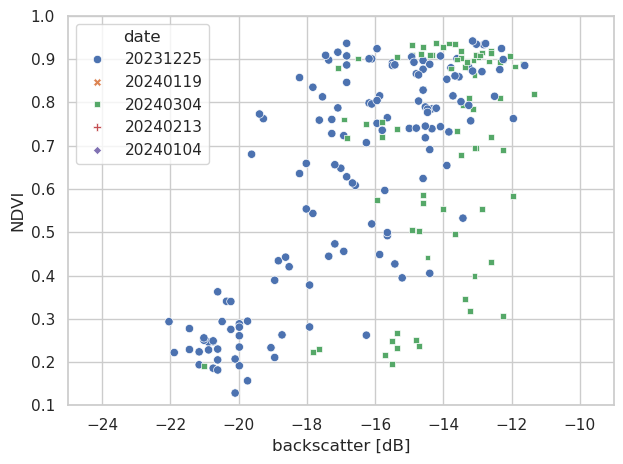

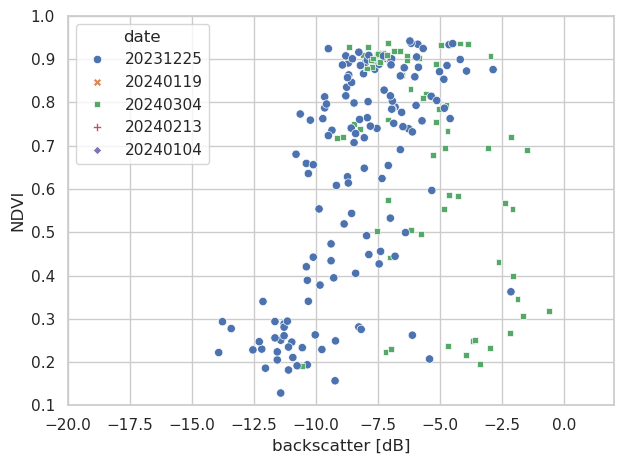

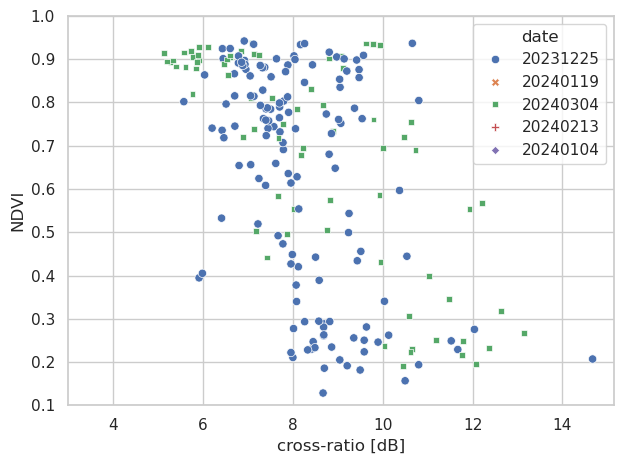

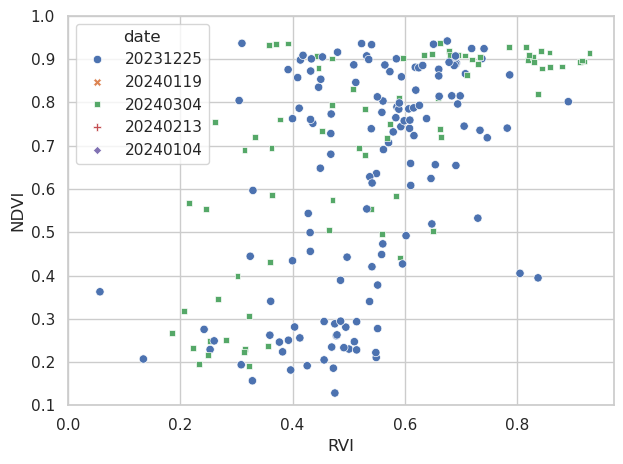

In [54]:
for dataname, xlim, xlabel in zip(datanames, xlims, xlabels):
    joined_pol = _joined[_joined.polarization == dataname]
    scatterplot_nice(x="median_novasar", y="median_s2", hue="s2_date", style="s2_date",
                     data=joined_pol,
                     xlabel=xlabel, ylabel="NDVI", huelabel="date",
                     xlim=xlim,
                     title=None)
    plt.savefig(fig_out_dir / f"novasar-{dataname.lower()}-ndvi-s2-colordate.pdf")
    plt.show()

### All fields, crop colored

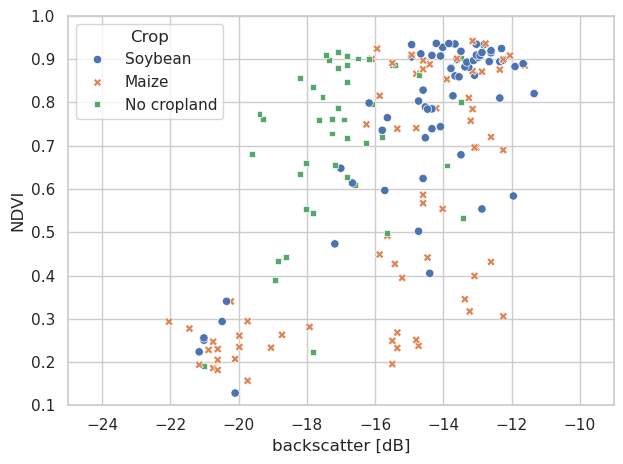

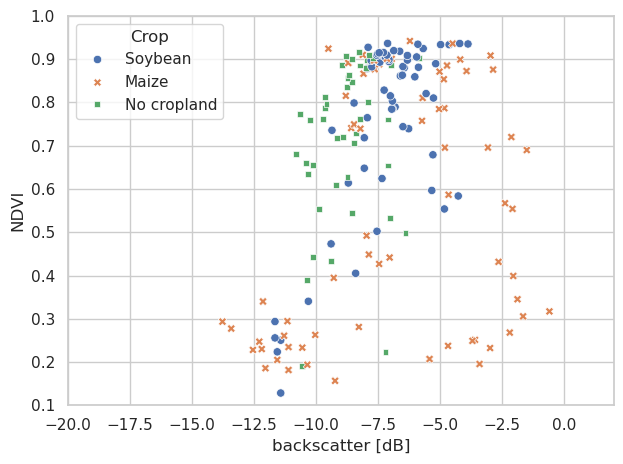

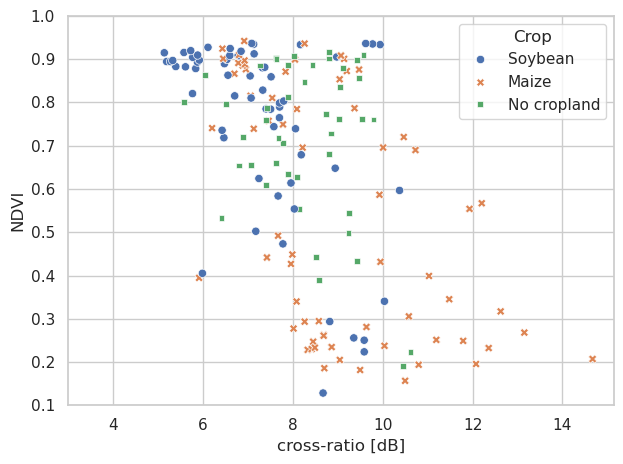

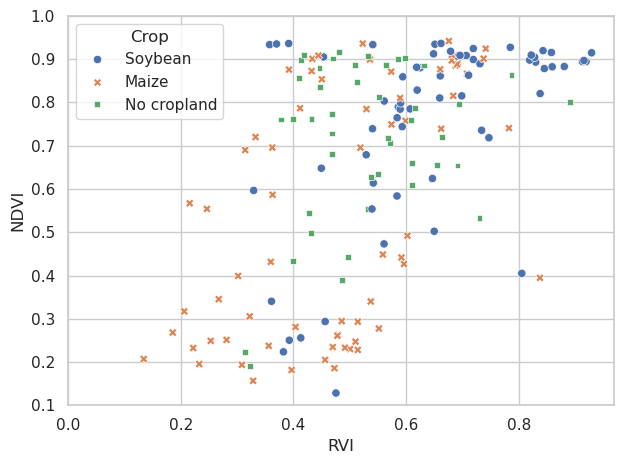

In [55]:
joined_no_empty = _joined[_joined.primary_class != "empty"]
for dataname, xlim, xlabel in zip(datanames, xlims, xlabels):
    joined_pol = joined_no_empty[joined_no_empty.polarization == dataname]
    joined_pol = joined_pol.sort_values("mean_s2")
    joined_pol = joined_pol[joined_pol.primary_class_fraction >= 0.9]
    scatterplot_nice(x="median_novasar", y="median_s2", hue="primary_class", 
                     style="primary_class",
                     data=joined_pol,
                     xlabel=xlabel, ylabel="NDVI", huelabel="Crop",
                     xlim=xlim, title=None)
    plt.savefig(fig_out_dir / f"novasar-{dataname.lower()}-ndvi-s2-colorclass.pdf")
    plt.show()

### thee subplots for each crop

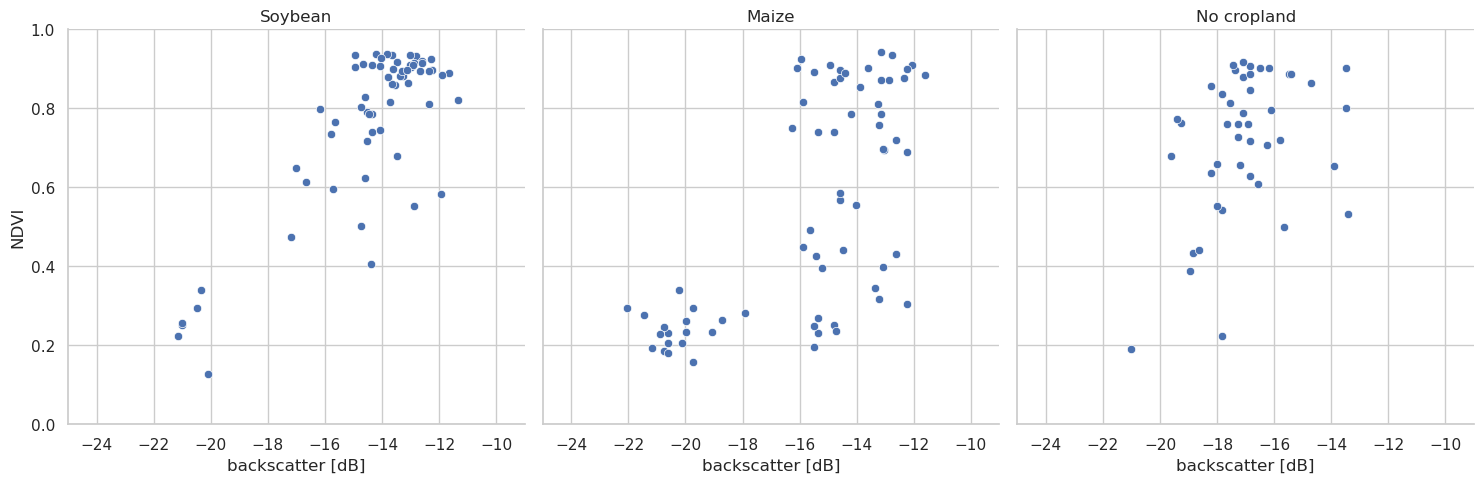

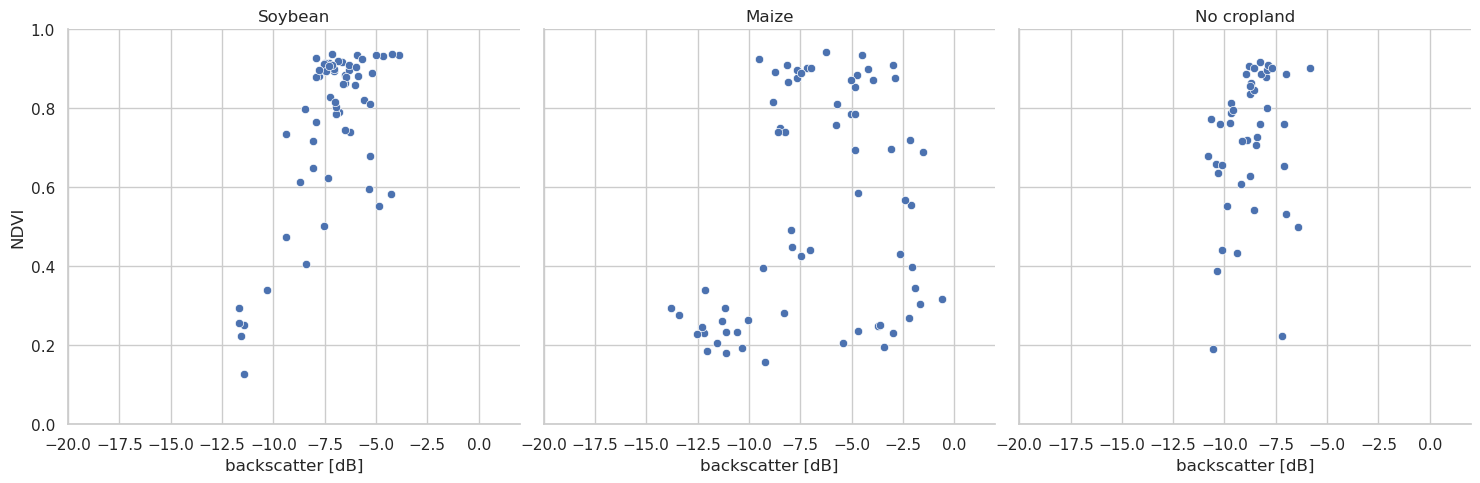

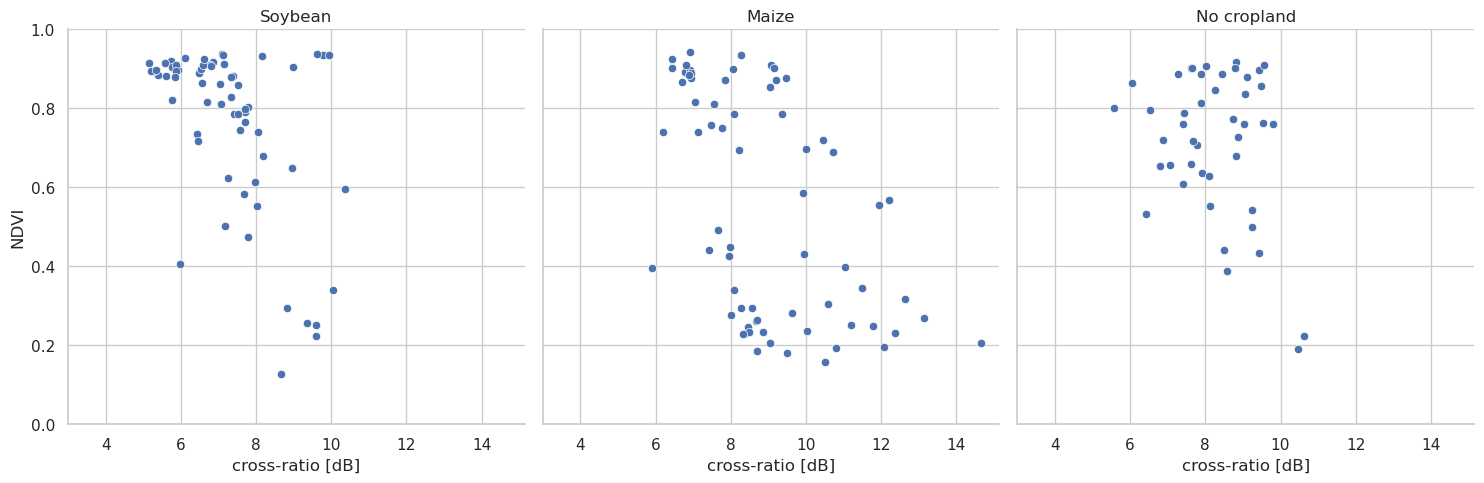

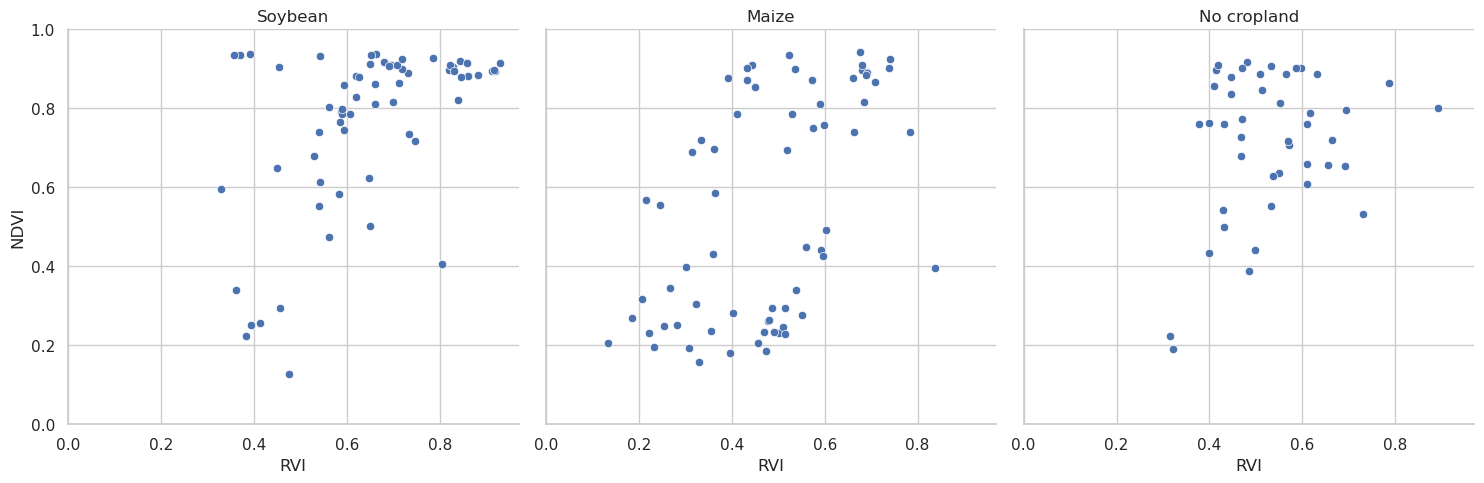

In [56]:
for dataname, xlim, xlabel in zip(datanames, xlims, xlabels):
    joined_pol = _joined[_joined.polarization == dataname]
    joined_pol = joined_pol[joined_pol.primary_class_fraction >= 0.9]
    joined_pol = joined_pol[joined_pol.primary_class != "empty"]
    harker = sns.relplot(
        data=joined_pol, x="median_novasar", y="median_s2",
        col="primary_class", 
        kind="scatter",
    )
    harker.set_xlabels(xlabel)
    harker.set_ylabels("NDVI")
    harker.set_titles("{col_name}")
    plt.xlim(*xlim)
    plt.ylim([0, 1])
    plt.savefig(fig_out_dir / f"{sensor}-{dataname.lower()}-ndvi-s2-seperateclassplots.pdf")
    plt.show()

# Visualization Sentinel-1

In [57]:
sensor = "s1"

In [58]:
print("S1:", stats_s1.date.unique())
print("S2:", stats_s2_df.date.unique())

S1: ['20240113' '20231220' '20240101' '20240301' '20240218' '20240325']
S2: ['20231225' '20240304']


## Data mangling

In [59]:
_s2_date_of_s1_img = stats_s1.loc[:, "date"].map(lambda d: s1_s2_date_mapping[d]).copy()
stats_s1.loc[:, "s2_date"] = _s2_date_of_s1_img
stats_s1

,mean,median,count,polygon_id,filename,polarization,local_incidence_angle,date,s2_date
0,-8.352342,-8.269309,4765,0,Subset_S1A_IW_GRDH_1SDV_20240113T093121_202401...,VV,36.133057,20240113,20240119
...,...,...,...,...,...,...,...,...,...
4919,-12.312737,6.669735,2033,204,Subset_S1A_IW_GRDH_1SDV_20240325T093120_202403...,CR,35.193321,20240325,20240324


In [60]:
joined_s1 = stats_s1.merge(right=stats_s2_df,  
                                how="inner",
                                left_on=('polygon_id', 's2_date'), 
                                right_on=('polygon_id', "date"), 
                                suffixes=('_s1', '_s2'))
joined_s1 = joined_s1[~pd.isnull(joined_s1.date_s2)]
joined_s1 = joined_s1[~pd.isnull(joined_s1.count_s1)]
joined_s1

,mean_s1,median_s1,count_s1,polygon_id,filename_s1,polarization,local_incidence_angle,date_s1,s2_date,mean_s2,median_s2,count_s2,filename_s2,date_s2,primary_class,primary_class_fraction,secondary_class,secondary_class_fraction
0,-9.656775,-9.564407,4764,0,Subset_S1A_IW_GRDH_1SDV_20231220T093122_202312...,VV,36.139301,20231220,20231225,0.778276,0.789675,3998,S2A_MSIL2A_20231225T140701_N0510_R110_T20HNK_2...,20231225,Soybean,0.99811,Maize,0.001890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,-8.435707,7.846931,2028,204,Subset_S1A_IW_GRDH_1SDV_20240301T093120_202403...,CR,35.181652,20240301,20240304,0.700374,0.754304,1704,S2A_MSIL2A_20240304T140711_N0510_R110_T20HNJ_2...,20240304,Maize,0.60000,Soybean,0.395556


In [61]:
joined_s1.to_csv(fig_out_dir / "statistics-sentinel1-ndvi.csv")

In [62]:
_joined = joined_s1.copy()
_joined = _joined[_joined.mean_s2 < .98]

## Plotting

In [63]:
sensor = "s1"
datanames = ["VV", "VH", "CR", "RVI"]
xlims = [(-20, -2.5), (-30, -11), None, None]
xlabels = ["backscatter [dB]", "backscatter [dB]", "cross-ratio [dB]", "RVI"]

### all fields, incidence angle colored

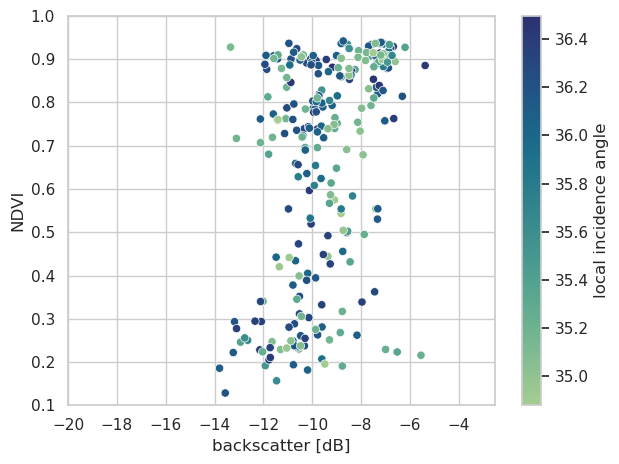

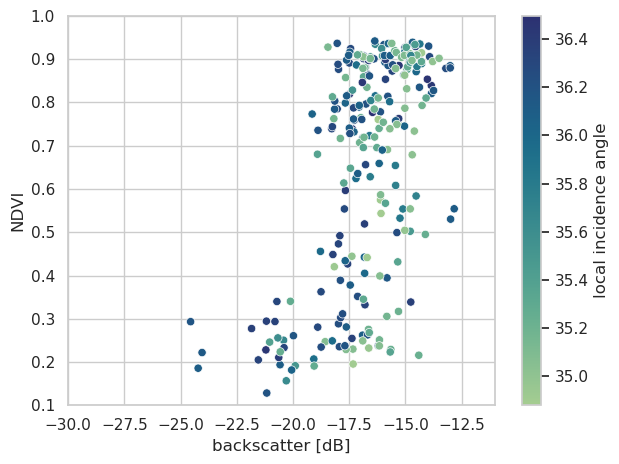

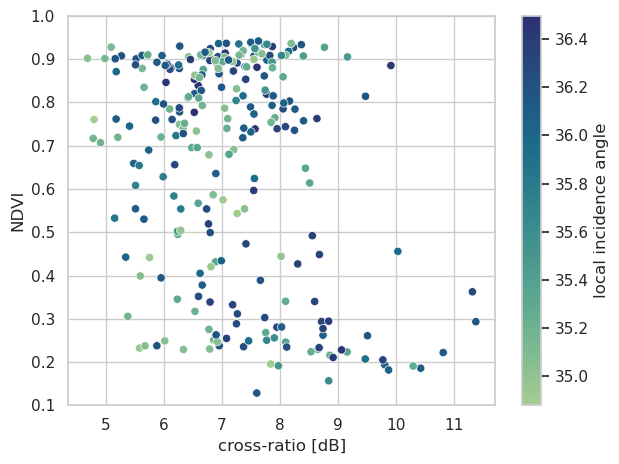

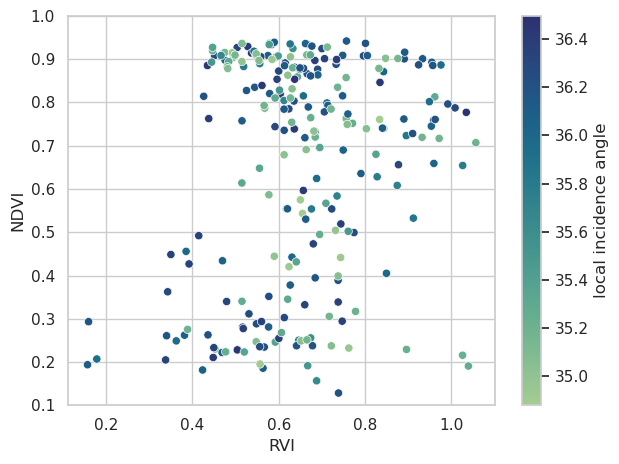

High p value! 0.006


In [64]:
for dataname, xlim, xlabel in zip(datanames, xlims, xlabels):
    joined_pol = _joined[_joined.polarization == dataname]
    scatterplot_nice(x="median_s1", y="median_s2", hue="local_incidence_angle", 
                     data=joined_pol,
                     xlabel=xlabel, ylabel="NDVI", huelabel="local incidence angle",
                     xlim=xlim,
                     title=None)
    plt.savefig(fig_out_dir / f"{sensor}-{dataname.lower()}-ndvi-s2-colorincidence.pdf")
    plt.show()
    pearsonsr_pol = get_filtered_pearsons_r(x="median_s1", y="median_s2", data=joined_pol)
    correlation_coeffs.append({"sensor": sensor, "polarization": dataname, "r": pearsonsr_pol["r"], "N": pearsonsr_pol["N"], "p": pearsonsr_pol["p"]})

### all fields, date colored

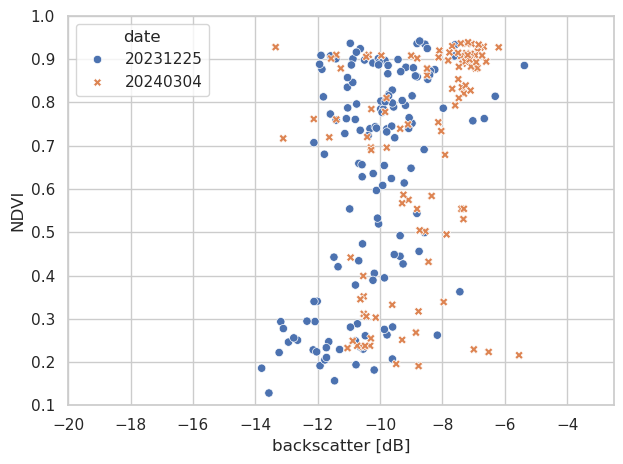

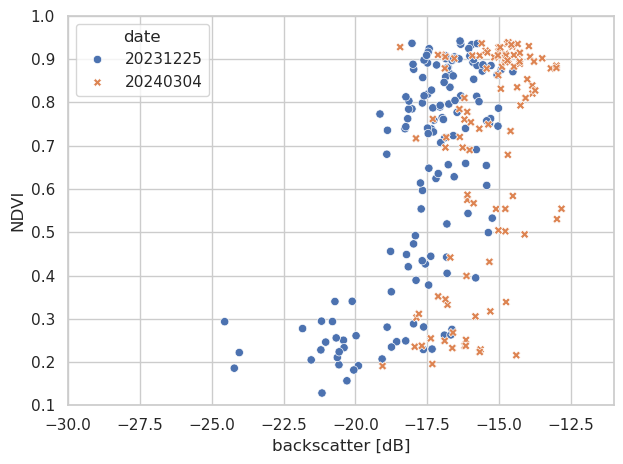

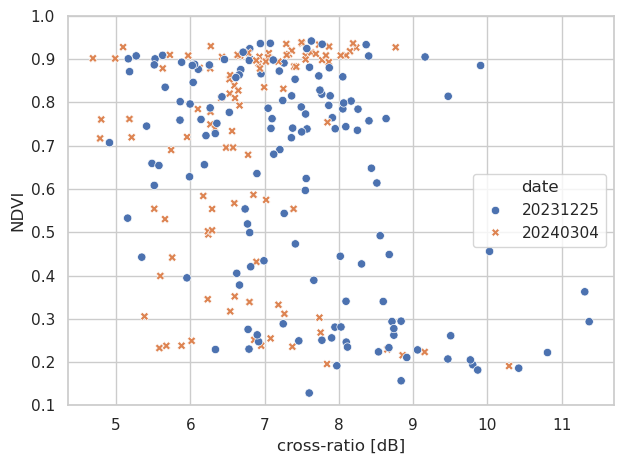

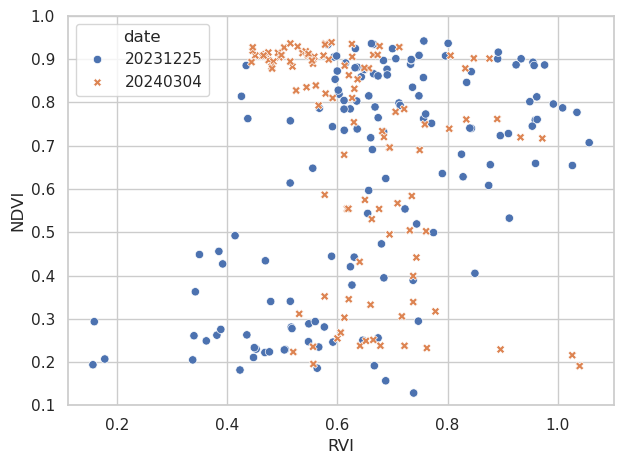

In [65]:
for dataname, xlim, xlabel in zip(datanames, xlims, xlabels):
    joined_pol = _joined[_joined.polarization == dataname]
    scatterplot_nice(x="median_s1", y="median_s2", hue="s2_date", 
                     data=joined_pol,
                     xlabel=xlabel, ylabel="NDVI", huelabel="date",
                     style="s2_date",
                     xlim=xlim,
                     title=None)
    plt.savefig(fig_out_dir / f"{sensor}-{dataname.lower()}-ndvi-s2-colordate.pdf")
    plt.show()

### all fields, crop type colored

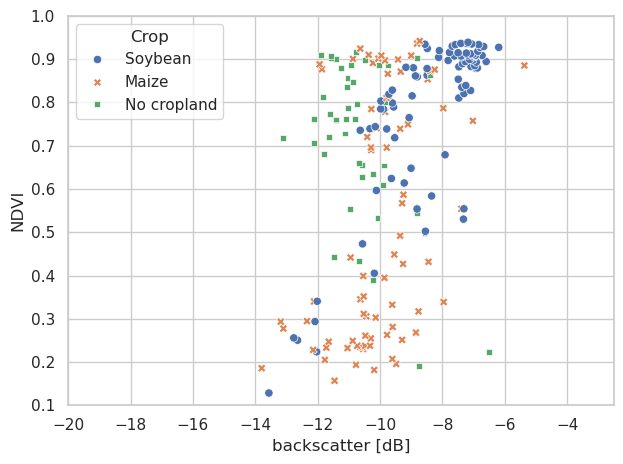

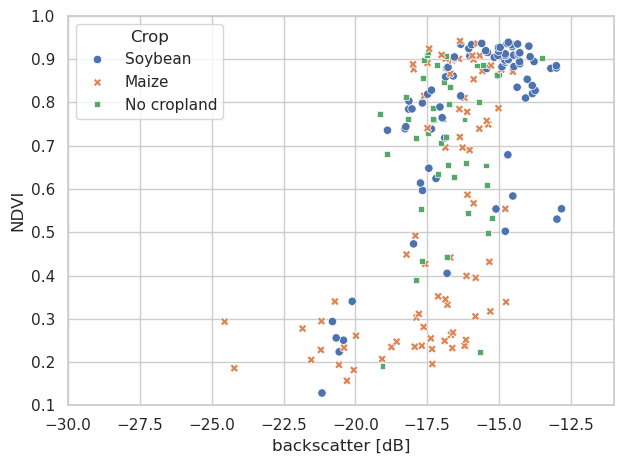

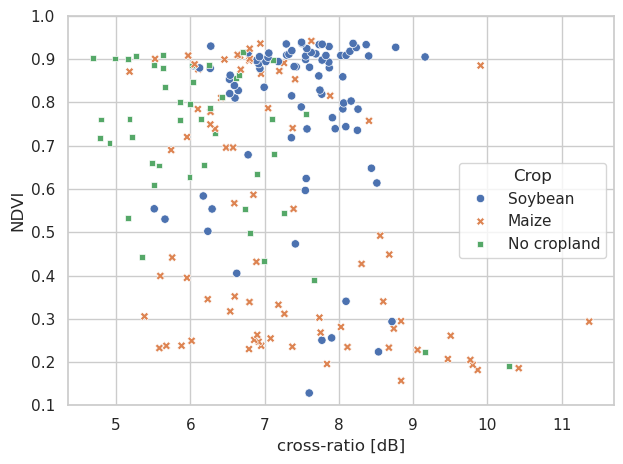

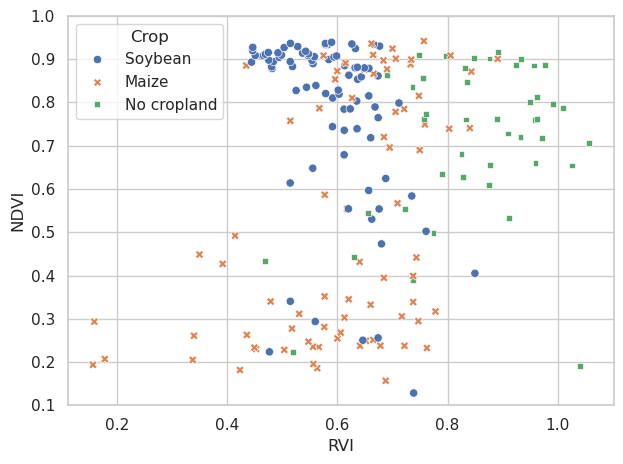

In [66]:
joined_no_empty = _joined[_joined.primary_class != "empty"]

for dataname, xlim, xlabel in zip(datanames, xlims, xlabels):
    joined_pol = joined_no_empty[joined_no_empty.polarization == dataname]
    joined_pol = joined_pol[joined_pol.primary_class_fraction >= 0.9]
    joined_pol = joined_pol.sort_values("median_s2")
    scatterplot_nice(x="median_s1", y="median_s2", hue="primary_class", 
                     style="primary_class",
                     data=joined_pol,
                     xlabel=xlabel, ylabel="NDVI", huelabel="Crop",
                     xlim=xlim,
                     title=None)
    plt.savefig(fig_out_dir / f"{sensor}-{dataname.lower()}-ndvi-s2-colorclass.pdf")
    plt.show()

### Plots for each crop

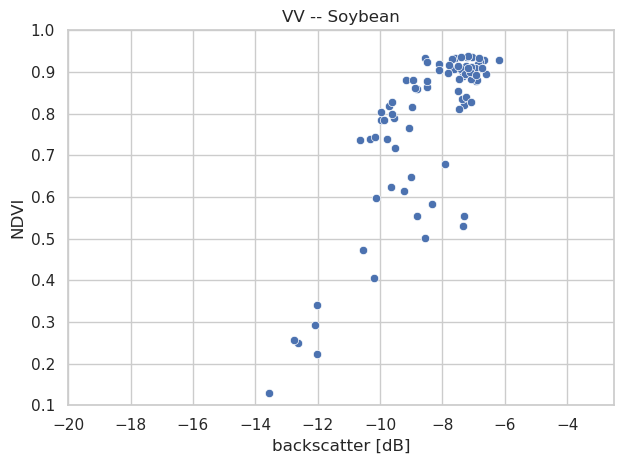

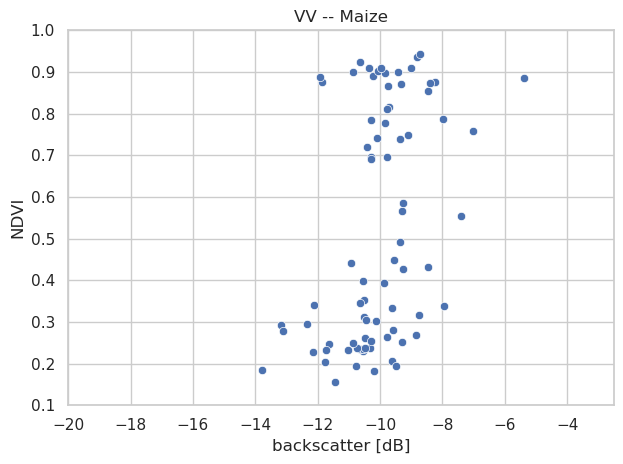

High p value! 0.004


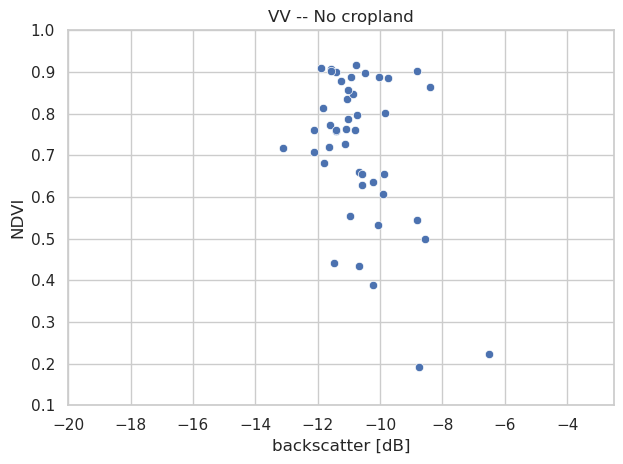

High p value! 0.205


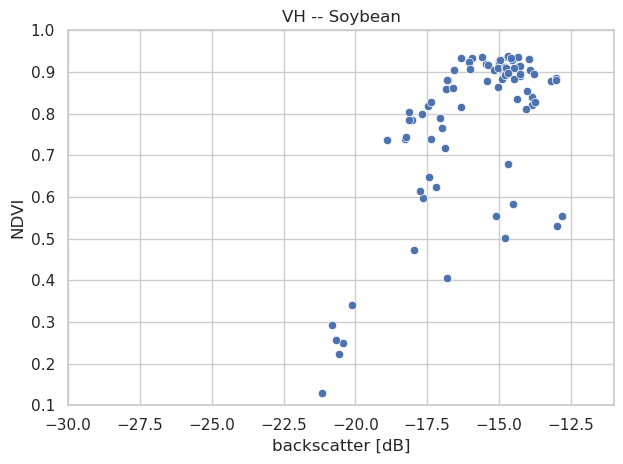

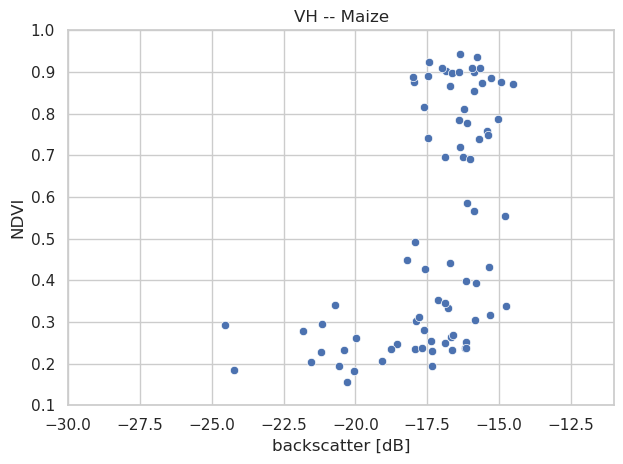

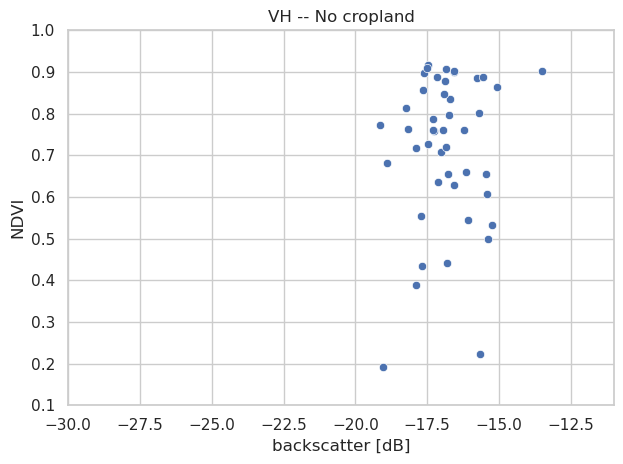

High p value! 0.499


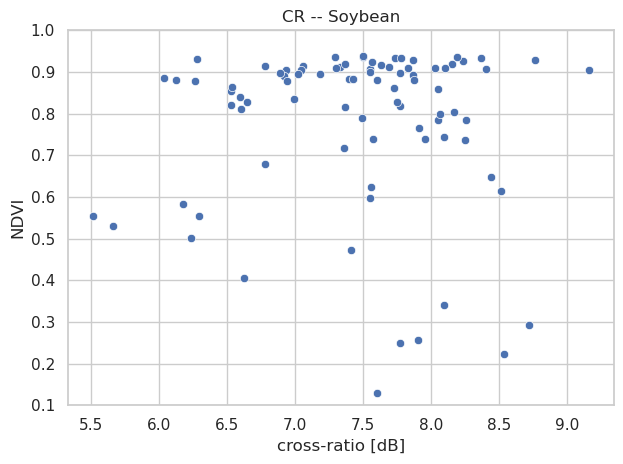

High p value! 0.590


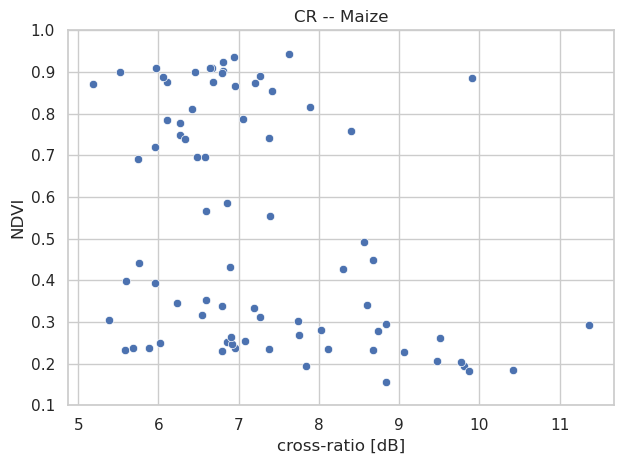

High p value! 0.002


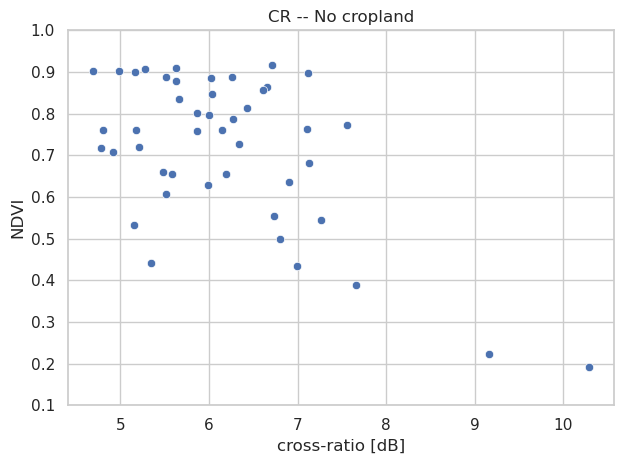

High p value! 0.002


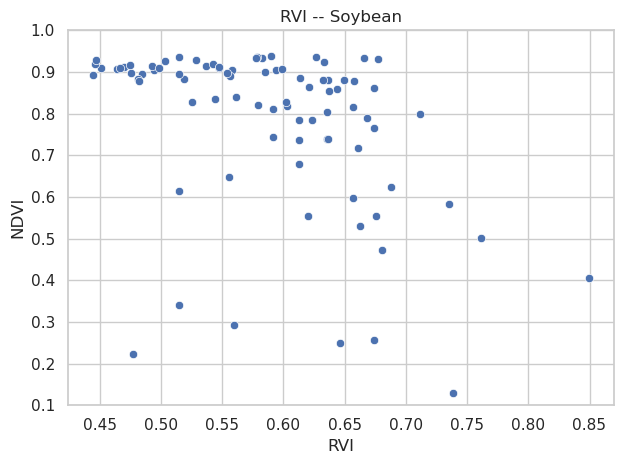

High p value! 0.003


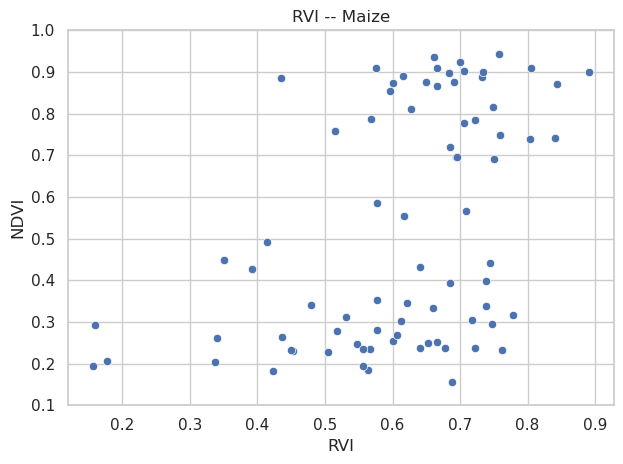

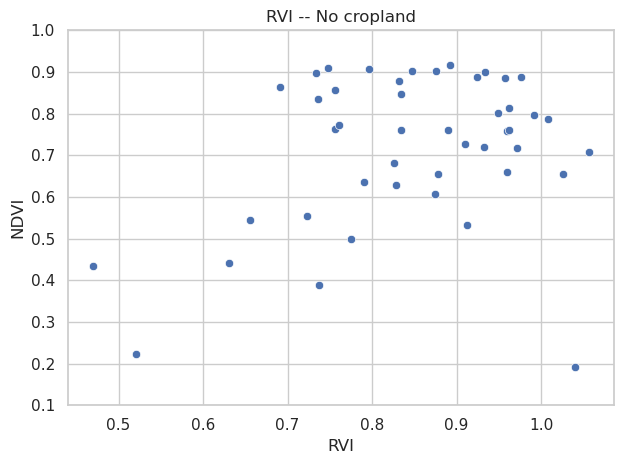

High p value! 0.005


In [67]:
for dataname, xlim, xlabel in zip(datanames, xlims, xlabels):
    joined_pol = _joined[_joined.polarization == dataname]
    joined_pol = joined_pol[joined_pol.primary_class_fraction >= 0.9]
    for primary_class in joined_pol.primary_class.unique():
        if primary_class in ["empty"]:
            continue
        data_cluster = joined_pol[joined_pol.primary_class == primary_class]
        scatterplot_nice(x="median_s1", y="median_s2", hue=None, huelabel=None,
                         data=data_cluster,
                         xlabel=xlabel, ylabel="NDVI",
                         xlim=xlim,
                         title=f"{dataname} -- {primary_class}")
        plt.savefig(fig_out_dir / f"{sensor}-{dataname.lower()}-ndvi-s2-{primary_class}.pdf")
        plt.show()
        
        dataname_classname =  f"{dataname}-{primary_class}"
        pearsonsr_pol = get_filtered_pearsons_r(x="median_s1", y="median_s2", data=data_cluster)
        correlation_coeffs.append({"sensor": sensor, "polarization": dataname_classname, "r": pearsonsr_pol["r"], "N": pearsonsr_pol["N"], "p": pearsonsr_pol["p"]})

### Three subplots with the crop type for each polarization/data type

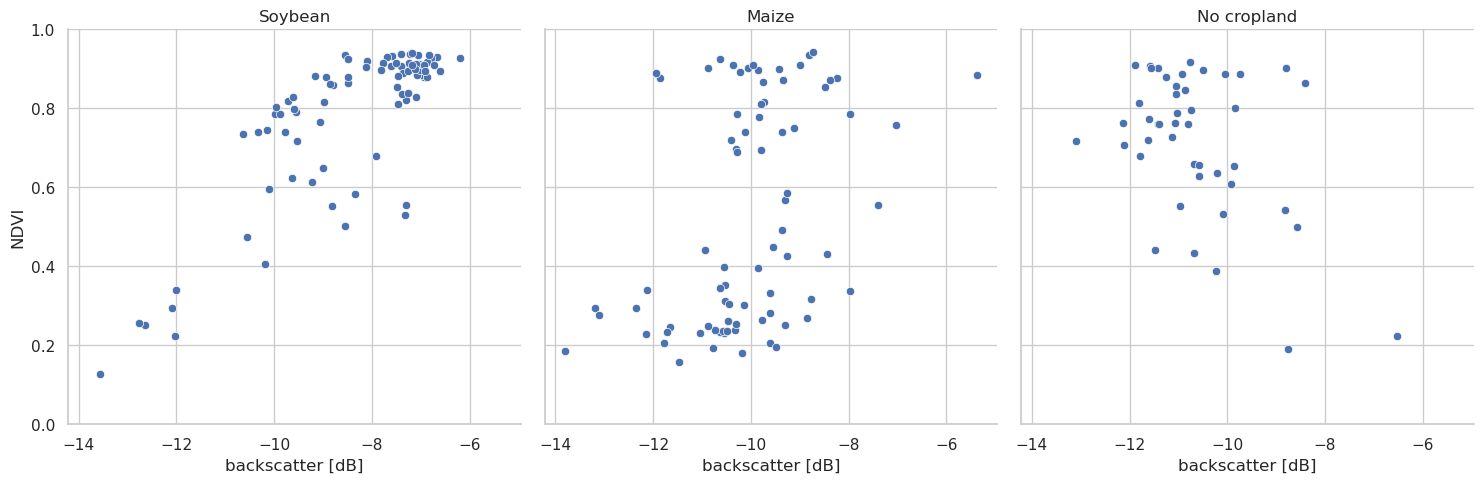

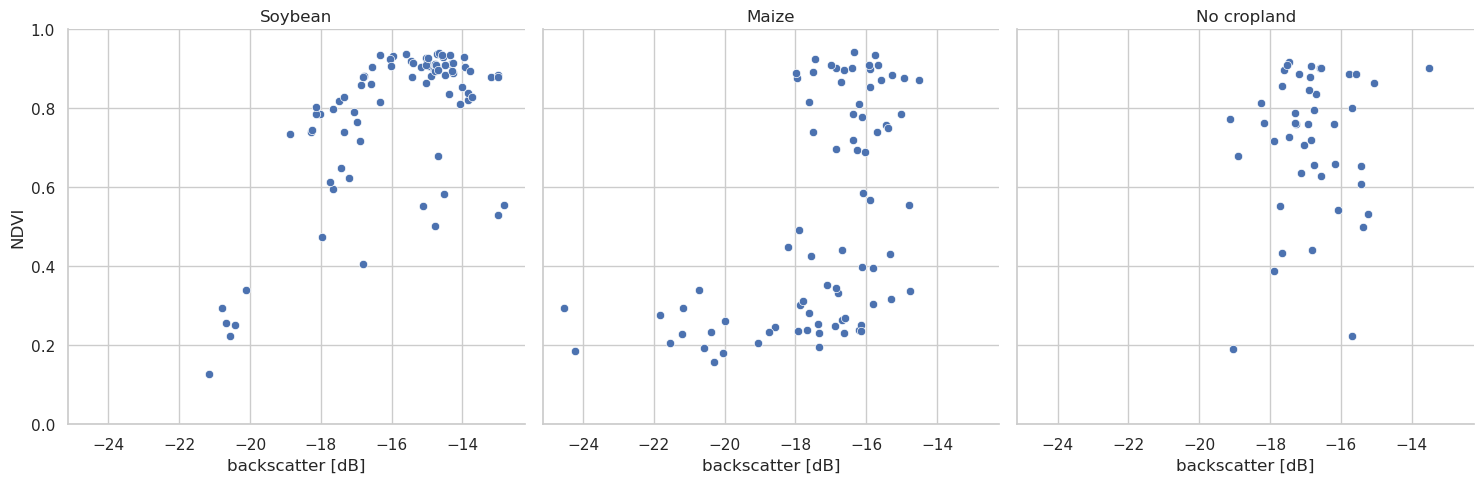

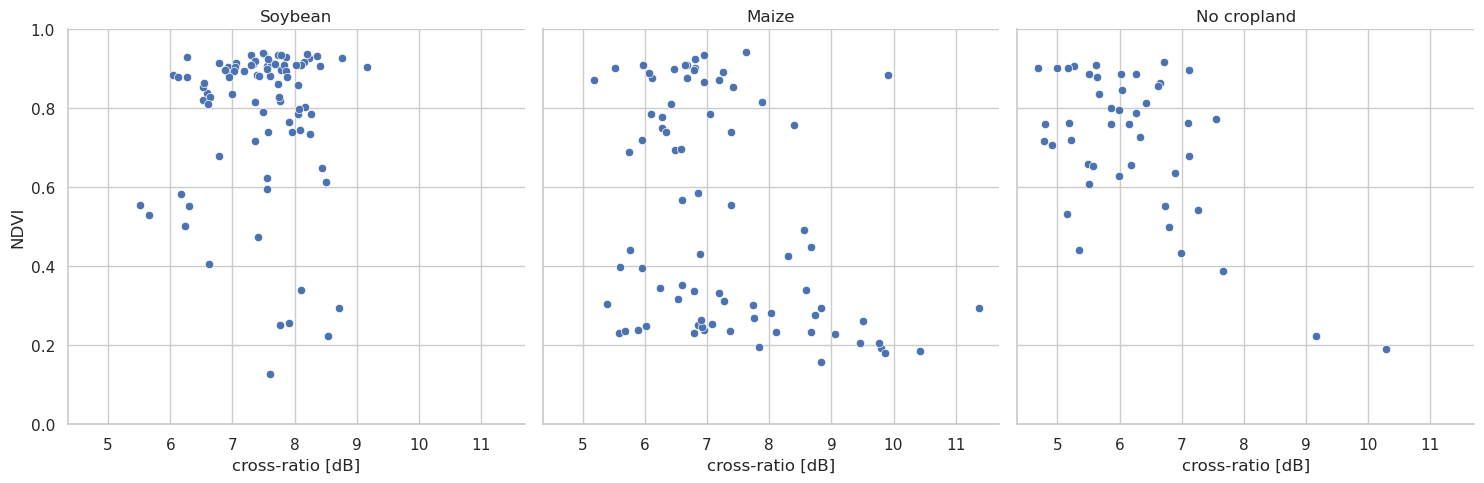

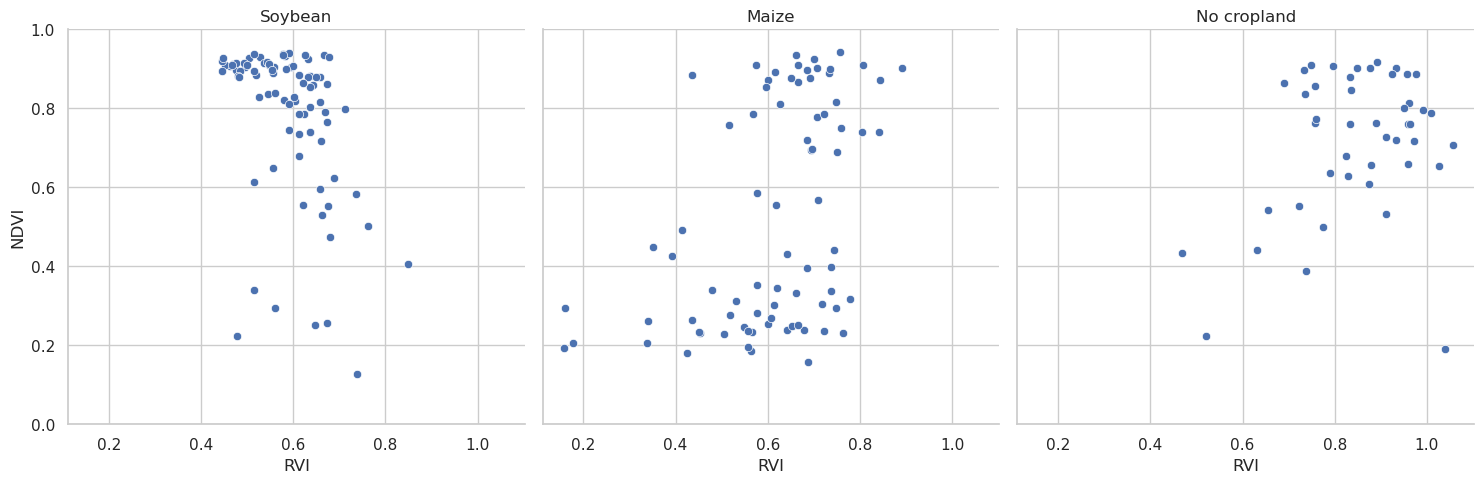

In [68]:
for dataname, xlim, xlabel in zip(datanames, xlims, xlabels):
    joined_pol = _joined[_joined.polarization == dataname]
    joined_pol = joined_pol[joined_pol.primary_class_fraction >= 0.9]
    joined_pol = joined_pol[joined_pol.primary_class != "empty"]
    harker = sns.relplot(
        data=joined_pol, x="median_s1", y="median_s2",
        col="primary_class", #hue="local_incidence_angle", #style="day",
        kind="scatter",
    )
    harker.set_xlabels(xlabel)#, clear_inner=False)
    harker.set_ylabels("NDVI")#, clear_inner=False)
    harker.set_titles("{col_name}")
    plt.ylim([0, 1])
    plt.savefig(fig_out_dir / f"{sensor}-{dataname.lower()}-ndvi-s2-seperateclassplots.pdf")
    plt.show()

# Correlation coefficient table

In [69]:
pearsonsr_df = pd.DataFrame(correlation_coeffs)
print(pearsonsr_df[["sensor", "polarization", "N","r", "p"]].to_markdown())
print(pearsonsr_df[["sensor", "polarization", "N","r", "p"]].style.format({"r": '{:.2f}', "p": "{:.3f}"},).to_latex(hrules=True))

|    | sensor   | polarization    |   N |          r |           p |
|---:|:---------|:----------------|----:|-----------:|------------:|
|  0 | novasar  | HV              | 210 |  0.648269  | 2.01692e-26 |
|  1 | novasar  | HH              | 207 |  0.320264  | 2.54616e-06 |
|  2 | novasar  | CR              | 206 | -0.551003  | 9.37694e-18 |
|  3 | novasar  | RVI             | 207 |  0.542688  | 2.9951e-17  |
|  4 | s1       | VV              | 237 |  0.424842  | 8.36263e-12 |
|  5 | s1       | VH              | 236 |  0.539361  | 3.25567e-19 |
|  6 | s1       | CR              | 236 | -0.255465  | 7.19426e-05 |
|  7 | s1       | RVI             | 236 |  0.178887  | 0.00585523  |
|  8 | s1       | VV-Soybean      |  81 |  0.776495  | 1.63228e-17 |
|  9 | s1       | VV-Maize        |  74 |  0.330234  | 0.00405948  |
| 10 | s1       | VV-No cropland  |  41 | -0.202246  | 0.204758    |
| 11 | s1       | VH-Soybean      |  81 |  0.665488  | 1.22252e-11 |
| 12 | s1       | VH-Maize        

## Extract crop wise tables from all the data

In [70]:
pearsonsr_df_all = pearsonsr_df[~pearsonsr_df['polarization'].str.contains('-')]
pearsonsr_df_all.loc[:, 'class'] = "all"
pearsonsr_df_all.drop(columns=["p"])
None

/tmp/ipykernel_16123/2997901354.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pearsonsr_df_all.loc[:, 'class'] = "all"


In [71]:
from IPython.display import display

In [72]:
pearsonsr_df_classwise = pearsonsr_df[pearsonsr_df['polarization'].str.contains('-')].copy()
pearsonsr_df_classwise['class'] = pearsonsr_df_classwise['polarization'].str.split('-').str[1]
pearsonsr_df_classwise['polarization'] = pearsonsr_df_classwise['polarization'].str.split('-').str[0]
for cl in pearsonsr_df_classwise["class"].unique():
    md = pearsonsr_df_classwise.drop(columns=["p"])[pearsonsr_df_classwise["class"] == cl]
    md = md[["sensor", "polarization", "N", "r", "class"]]  # reorder columns
    display(md)

,sensor,polarization,N,r,class
8,s1,VV,81,0.776495,Soybean
11,s1,VH,81,0.665488,Soybean
14,s1,CR,80,-0.061132,Soybean
17,s1,RVI,80,-0.326609,Soybean


,sensor,polarization,N,r,class
9,s1,VV,74,0.330234,Maize
12,s1,VH,74,0.488939,Maize
15,s1,CR,74,-0.348580,Maize
18,s1,RVI,74,0.417959,Maize


,sensor,polarization,N,r,class
10,s1,VV,41,-0.202246,No cropland
13,s1,VH,41,-0.108542,No cropland
16,s1,CR,42,-0.456341,No cropland
19,s1,RVI,41,0.430081,No cropland
